In [ ]:
!pip install fingerprint-enhancer
!pip install pyeer

     |████████████████████████████████| 14.6MB 268kB/s 
  Created wheel for fingerprint-enhancer: filename=fingerprint_enhancer-0.0.11-cp37-none-any.whl size=8045 sha256=71a6f1d008c18b46c16ec2c442e3ccd6e38a6d408579ced3c80c4c4370a11729
  Stored in directory: /root/.cache/pip/wheels/88/45/5c/3d34ba8efab7e215b7e8cb712752e2aa24ef12cb7e75fc6d22
Successfully built fingerprint-enhancer
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.19.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 614kB 5.3MB/s 
  Created wheel for pyeer: filename=pyeer-0.5.5-cp37-none-any.whl size=604267 sha256=ad96084a2c232d517335802da6d71740f615d1737cbc1b6625103ea3cbf9efe2
  Stored in directory: /root/.cache/pip/wheels/11/84/dc/8c50eb806263b6d79c80864c2ab52d8a8bc6cbbb5a9d224110
Successfully built pyeer


In [ ]:
!git clone https://github.com/tungrg/fpr1.git

Cloning into 'fpr1'...
remote: Enumerating objects: 1001, done.
remote: Counting objects: 100% (1001/1001), done.
remote: Compressing objects: 100% (897/897), done.
remote: Total 1001 (delta 99), reused 1001 (delta 99), pack-reused 0
Receiving objects: 100% (1001/1001), 75.39 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
%cd fpr1
%ls

/content/fpr1
fvc2002/  fvc2004/


In [ ]:
import cv2
import numpy as np
import operator
from matplotlib import pyplot as plt
import glob
import fingerprint_enhancer as fe
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
# pyeer library: pip install pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# 1 Load image

In [ ]:
def read_images(IMAGES_PATH):
  #doc cac anh tu duong dan
    file_names = [img for img in glob.glob(IMAGES_PATH + "/*.tif")]
    #sort lai ten de ty phan lop cho de
    file_names.sort()
    return file_names

In [ ]:
def get_image_label(filename):
  #tach ten anh ra
    image = filename.split('/')
    return image[len(image)-1]

In [ ]:
def get_image_class(filename):
  #lay class cua anh thuoc ve ngon tay nao
    return get_image_label(filename).split('_')[0]

In [ ]:
# Splits the dataset on training and testing set
def split_dataset(data, test_size):
    train, test = train_test_split(data, test_size=test_size, random_state=42)
    return train, test

In [ ]:
def grayscale_image(image):
  #grayscale ảnh lại
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
def enhance_image(image):
  #enhance dấu vân tay
    img_e = fe.enhance_Fingerprint(image)
    return cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)

In [ ]:
def prepare_dataset(file_names):
    #chuẩn bị data_set, train_set là bộ dữ liệu base, valid_set để lấy trọng số, test_set là bộ dữ liệu để kiểm tra
    train_set = {}
    valid_set = {}
    test_set = {}
    data = []  # list of tuples
    temp_label = get_image_class(file_names[0])  # sets the image class (101)

    for filename in file_names:
        img = cv2.imread(filename)
        gray_img = grayscale_image(img)
        img = enhance_image(gray_img)
        label = get_image_label(filename)
        #print('Processing image {} ...  '.format(label))
        if temp_label != get_image_class(filename):
            train, test = split_dataset(data, 0.2)
            train_real, valid = split_dataset(train, 0.3)
            train_set.update(train_real)
            valid_set.update(valid)
            test_set.update(test)
            temp_label = get_image_class(filename)
            data = []
        data.append((label, img))

        if filename == file_names[len(file_names) - 1]:
            train, test = split_dataset(data, 0.2)
            train_real, valid = split_dataset(train, 0.3)
            train_set.update(train_real)
            valid_set.update(valid)
            test_set.update(test)

    print('DONE')
    return train_set, valid_set, test_set

# 2 Rut trich dac trung

In [ ]:
#khoi tao orb
orb = cv2.ORB_create() #bộ rút trích đặc trưng
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) #bộ đối sánh

In [ ]:
# Rút trích đặc trưng của dataset
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

# 3 Đối sánh

In [ ]:
# Đối sánh đặc trưng của của ảnh query và base đặc trưng của những ngón tay đã được rút trích
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # rút trích đặc trưng của query
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sắp xếp lại dựa trên khoảng cách đặc trưng
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold] #chỉ giữ lại những đặc trưng dưới  threshold
            best_matches_dict[train_image_id] = len(best_matches) # lấy tổng số đặc trưng
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort lại dựa theo tổng số đặc trưng
    return best_matches_dict

In [ ]:
def draw_keypoints_matches(fpr1, fpr2):
  #vẽ để so sánh 2 ngón tay
    kp1, des1 = orb.detectAndCompute(fpr1, None) 
    kp2, des2 = orb.detectAndCompute(fpr2, None)

    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)

    plt.imshow(imMatches)
    plt.show()

# 4 Xác minh danh tính

Ở đây ta giải quyết bài toán xác minh 1:1.

Cho bài toán xác minh danh tính, bộ test_set và valid_set vẫn được giữ nguyên.Còn về bộ train_set (base feature) đã được tính toán, sẽ được chia thành các   dictionaries tách biệt  mà key sẽ tượng trưng cho danh tính của dấu vân tay và mỗi ảnh sẽ tượng trưng cho 1 biểu hiện của dấu vân tay đó.

In [ ]:
def prepare_dataset_authentication(train_feature_descriptors):
    #Chia train_set thành db để chuẩn bị cho việc xác minh danh tính
    authentication_databases = {}
    temp_list = {}
    class_name = get_image_class(list(train_feature_descriptors.keys())[0])  # inital class name
    last_key = list(train_feature_descriptors.keys())[-1]

    for image_id, feature_descriptor in train_feature_descriptors.items():
        if class_name != get_image_class(image_id):
            authentication_databases[class_name] = temp_list
            temp_list = {}
        temp_list[image_id] = feature_descriptor
        class_name = get_image_class(image_id)

        if last_key == image_id:
            authentication_databases[class_name] = temp_list

    return authentication_databases


In [ ]:
def count_same_fprs(feature_distances, len_best_matches):
    #tính toán xem có bao nhiêu dấu vân tay qua ngưỡng threshold trong db
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: 
            count_same += 1
            
    return count_same

In [ ]:
def perform_authentication_scenario(dist_threshold, len_best_matches,authentication_databases, test_set_exam):
    #thực hiện xác minh danh tính
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, threshold = {}, len = {} -----".format(dist_threshold, len_best_matches))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image in test_set_exam.items():    
            best_matches_dict = get_best_matches(test_image, authentication_db, dist_threshold)

            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            total_distances.append(ratio)
            if ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
    accuracy = accuracy_score(true_y, pred_y)
    print("Accuracy is %f "%(accuracy_score(true_y, pred_y)))
    return accuracy, total_distances,true_y

Tìm trọng số threshold tốt nhất cho việc xác minh

In [ ]:
def find_optimal_authen(authentication_databases, test_set_exam):
  max_acc = 0
  for dist_threshold in range(30, 90, 10):
    for len_best_matches in range(10,40,5):
      temp,_,_ = perform_authentication_scenario(dist_threshold, len_best_matches,authentication_databases, test_set_exam)
      if (max_acc <= temp):
        optimal_authen = (dist_threshold, len_best_matches)
        max_acc = temp
  return optimal_authen

In [ ]:
def get_genuine_impostor_scores(all_scores, identical):
    
    #genuine_score là điểm số khi xác minh đúng
    #impostor_score là điểm số khi xác minh sai
    genuine_scores = []
    impostor_scores = []
    for i in range(0, len(all_scores)):
        if identical[i] == 1:
            genuine_scores.append(all_scores[i])
        else:
            impostor_scores.append(all_scores[i])

    return genuine_scores, impostor_scores

Để trực quan hóa về kết quả của hệ thống nhận dạng, ta sử dụng ROC curve là đồ thị thể hiện tương quan của 2 độ đo FAR và FRR.

### Trực quan kết quả sử dụng ROC curve  (FAR vs FRR)

In [ ]:
def get_roc_curve(frr, far):
    plt.title('ROC curve')
    x_axis = np.array(far) # False Positive (Accept / Match) Rate
    y_axis = np.array(frr) # False Reject Rate = 1 - TPR
    plt.plot(x_axis, y_axis) # x, y
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('False Reject Rate (FRR)')
    plt.xlabel('False Accept Rate (FAR)')
    plt.grid(True)
    plt.show()

# 5 Đánh giá trên dataset fvc2002

FVC2002 được chia làm 4 bộ dataset lần lượt là db1_b, db2_b, db3_b, db4_b.
<br>
Bởi vì mỗi dataset được thu thập theo 1 cách khác nhau nên ta đánh giá trên từng dataset riêng biệt chứ không gộp chung.

In [ ]:
import time

# your code here    


##FVC2002

In [ ]:
fvc2002 = ['fvc2002/DB1_B','fvc2002/DB2_B', 'fvc2002/DB3_B', 'fvc2002/DB4_B']

###DB1_B

In [ ]:
image_files = read_images(fvc2002[0])

In [ ]:
start = time.process_time()
train_set,valid_set, test_set = prepare_dataset(image_files)
time_1_pre = time.process_time() - start

DONE


In [ ]:
start = time.process_time()
train_feature_descriptors = get_feature_descriptors(train_set)
time_1_extrac = time.process_time() - start

In [ ]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [ ]:
optimal_authen = find_optimal_authen(authentication_databases,valid_set)

----- START, threshold = 30, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 50, len = 10 -----
Accuracy is 0.905000 
----- START, threshold = 50, len = 15 -----
Accuracy is 0.915000 
----- START, threshold = 50, len = 20 -----
Accuracy is 0.915000 
----- STAR

In [ ]:
start = time.process_time()
_,distances, identical = perform_authentication_scenario(optimal_authen[0], optimal_authen[1],authentication_databases, test_set)
time_1_au = time.process_time() - start

----- START, threshold = 60, len = 35 -----
Accuracy is 0.920000 


In [ ]:
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

Equal Error Rate is: 0.2833


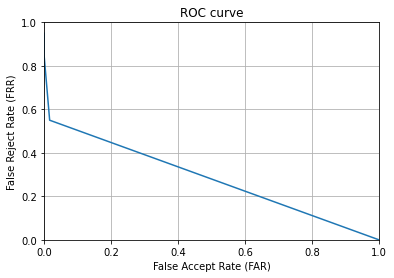

In [ ]:
stats = get_eer_stats(genuine_scores, impostor_scores)
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))
get_roc_curve(stats.fnmr, stats.fmr)

###DB2_B

In [ ]:
image_files = read_images(fvc2002[1])

In [ ]:
start = time.process_time()
train_set,valid_set, test_set = prepare_dataset(image_files)
time_2_pre = time.process_time() - start

DONE


In [ ]:
start = time.process_time()
train_feature_descriptors = get_feature_descriptors(train_set)
time_2_extrac = time.process_time() - start

In [ ]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [ ]:
optimal_authen = find_optimal_authen(authentication_databases,valid_set)

----- START, threshold = 30, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 10 -----
Accuracy is 0.905000 
----- START, threshold = 40, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 50, len = 10 -----
Accuracy is 0.645000 
----- START, threshold = 50, len = 15 -----
Accuracy is 0.885000 
----- START, threshold = 50, len = 20 -----
Accuracy is 0.930000 
----- STAR

In [ ]:
start = time.process_time()
_,distances, identical = perform_authentication_scenario(optimal_authen[0], optimal_authen[1],authentication_databases, test_set)
time_2_au = time.process_time() - start

----- START, threshold = 50, len = 20 -----
Accuracy is 0.915000 


In [ ]:
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

Equal Error Rate is: 0.1722


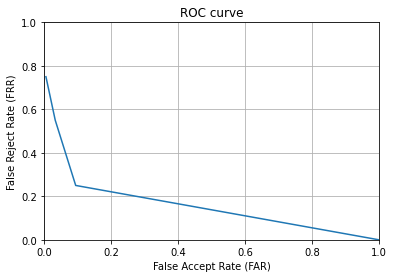

In [ ]:
stats = get_eer_stats(genuine_scores, impostor_scores)
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))
get_roc_curve(stats.fnmr, stats.fmr)

###DB3_B

In [ ]:
image_files = read_images(fvc2002[2])

In [ ]:
start = time.process_time()
train_set,valid_set, test_set = prepare_dataset(image_files)
time_3_pre = time.process_time() - start

DONE


In [ ]:
start = time.process_time()
train_feature_descriptors = get_feature_descriptors(train_set)
time_3_extrac = time.process_time() - start

In [ ]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [ ]:
optimal_authen = find_optimal_authen(authentication_databases,valid_set)

----- START, threshold = 30, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 10 -----
Accuracy is 0.905000 
----- START, threshold = 40, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 50, len = 10 -----
Accuracy is 0.905000 
----- START, threshold = 50, len = 15 -----
Accuracy is 0.910000 
----- START, threshold = 50, len = 20 -----
Accuracy is 0.910000 
----- STAR

In [ ]:
start = time.process_time()
_,distances, identical = perform_authentication_scenario(optimal_authen[0], optimal_authen[1],authentication_databases, test_set)
time_3_au = time.process_time() - start

----- START, threshold = 60, len = 25 -----
Accuracy is 0.905000 


In [ ]:
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

Equal Error Rate is: 0.2861


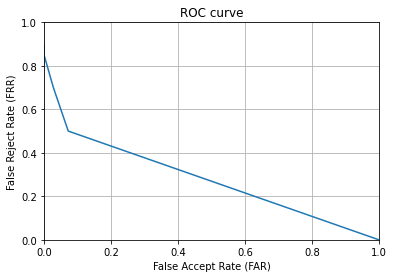

In [ ]:
stats = get_eer_stats(genuine_scores, impostor_scores)
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))
get_roc_curve(stats.fnmr, stats.fmr)

###DB4_B

In [ ]:
image_files = read_images(fvc2002[3])

In [ ]:
start = time.process_time()
train_set,valid_set, test_set = prepare_dataset(image_files)
time_4_pre = time.process_time() - start

DONE


In [ ]:
start = time.process_time()
train_feature_descriptors = get_feature_descriptors(train_set)
time_4_extrac = time.process_time() - start

In [ ]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [ ]:
optimal_authen = find_optimal_authen(authentication_databases,valid_set)

----- START, threshold = 30, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 30, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 10 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 15 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 20 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 25 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 30 -----
Accuracy is 0.900000 
----- START, threshold = 40, len = 35 -----
Accuracy is 0.900000 
----- START, threshold = 50, len = 10 -----
Accuracy is 0.595000 
----- START, threshold = 50, len = 15 -----
Accuracy is 0.800000 
----- START, threshold = 50, len = 20 -----
Accuracy is 0.885000 
----- STAR

In [ ]:
start = time.process_time()
_,distances, identical = perform_authentication_scenario(optimal_authen[0], optimal_authen[1],authentication_databases, test_set)
time_4_au = time.process_time() - start

----- START, threshold = 50, len = 35 -----
Accuracy is 0.900000 


In [ ]:
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

Equal Error Rate is: 0.475


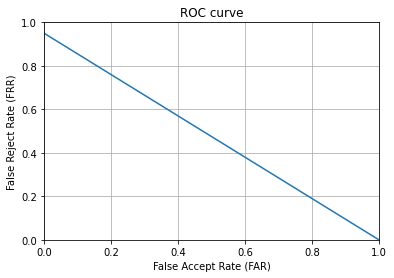

In [ ]:
stats = get_eer_stats(genuine_scores, impostor_scores)
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))
get_roc_curve(stats.fnmr, stats.fmr)

In [ ]:
print(time_1_pre +time_2_pre + time_3_pre+ time_4_pre)
print(time_1_extrac +time_2_extrac + time_3_extrac+ time_4_extrac)
print(time_1_au +time_2_au + time_3_au+ time_4_au)

1052.7108217169998
1.1689415849995157
46.4671445969999
